In [38]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import umap
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

sys.path.append(os.path.abspath('..')) 

from utils.preproc_utils import *
from utils.plot_utils import *
from utils.modeling_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
sys.path.append(os.path.abspath('..')) 
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/processed/'))

latent_rep_path = os.path.join(base_dir, 'latent_representation.csv')
latent_rep = pd.read_csv(latent_rep_path, index_col='customer_id')

latent_rep_path_outliers = os.path.join(base_dir, 'latent_representation_outliers.csv')
latent_rep_outliers = pd.read_csv(latent_rep_path_outliers, index_col='customer_id')

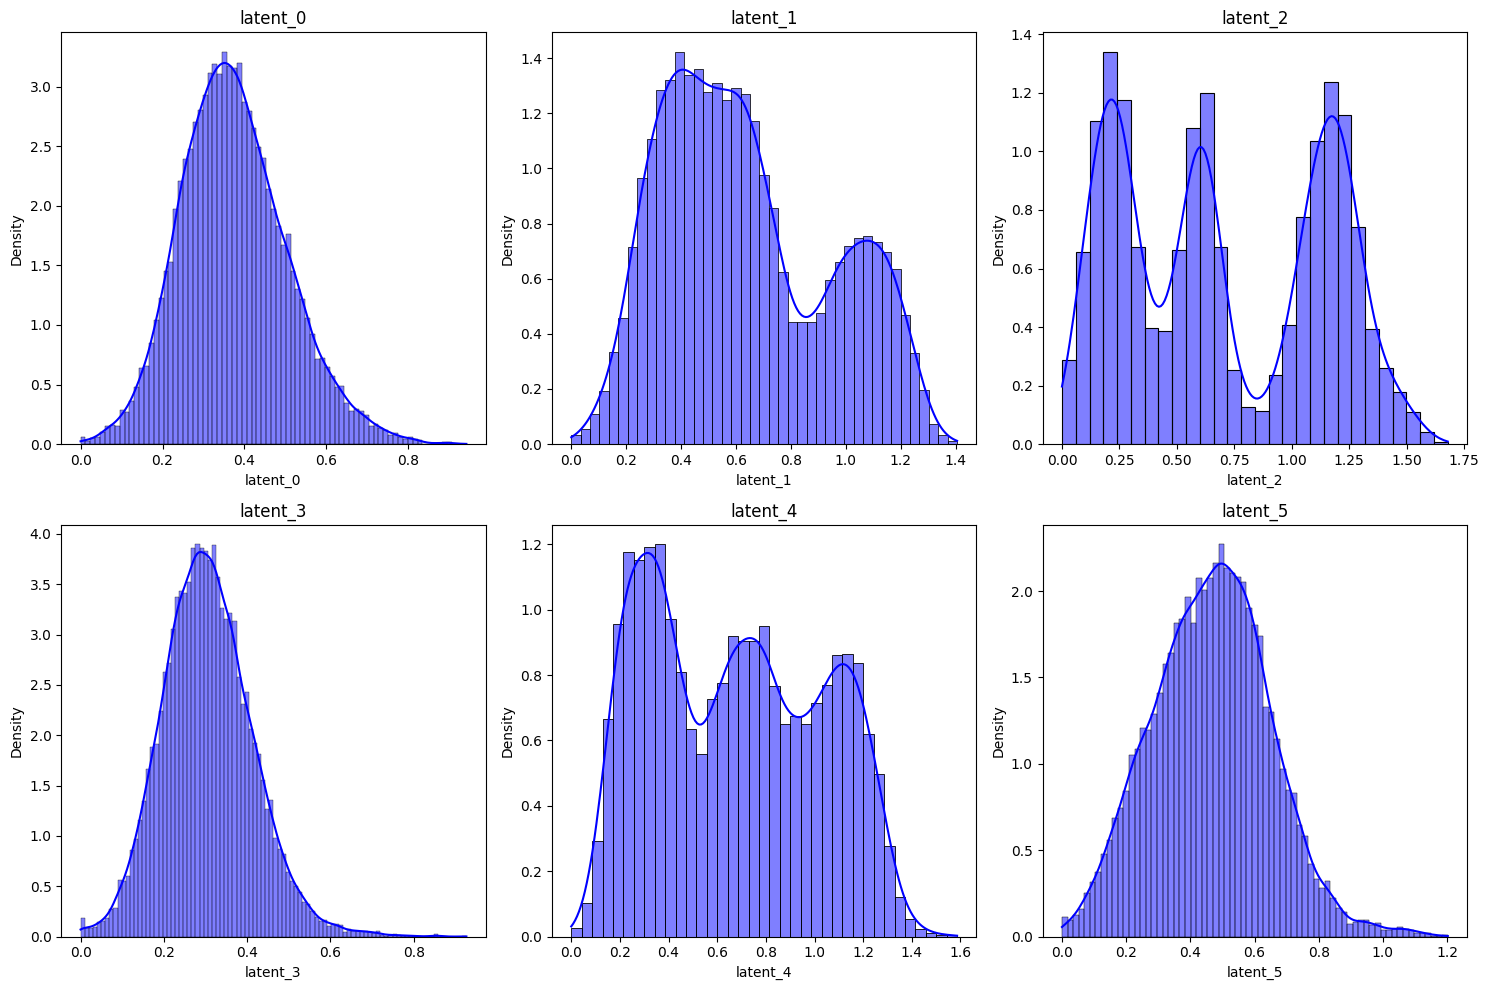

In [13]:
var_plotter(latent_rep, latent_rep.columns)

In [10]:
scaler = StandardScaler()
latent_rep_scaled = pd.DataFrame(scaler.fit_transform(latent_rep), columns=latent_rep.columns, index=latent_rep.index)
latent_rep_scaled_outliers = pd.DataFrame(scaler.transform(latent_rep_outliers), columns=latent_rep.columns, index=latent_rep_outliers.index)

c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

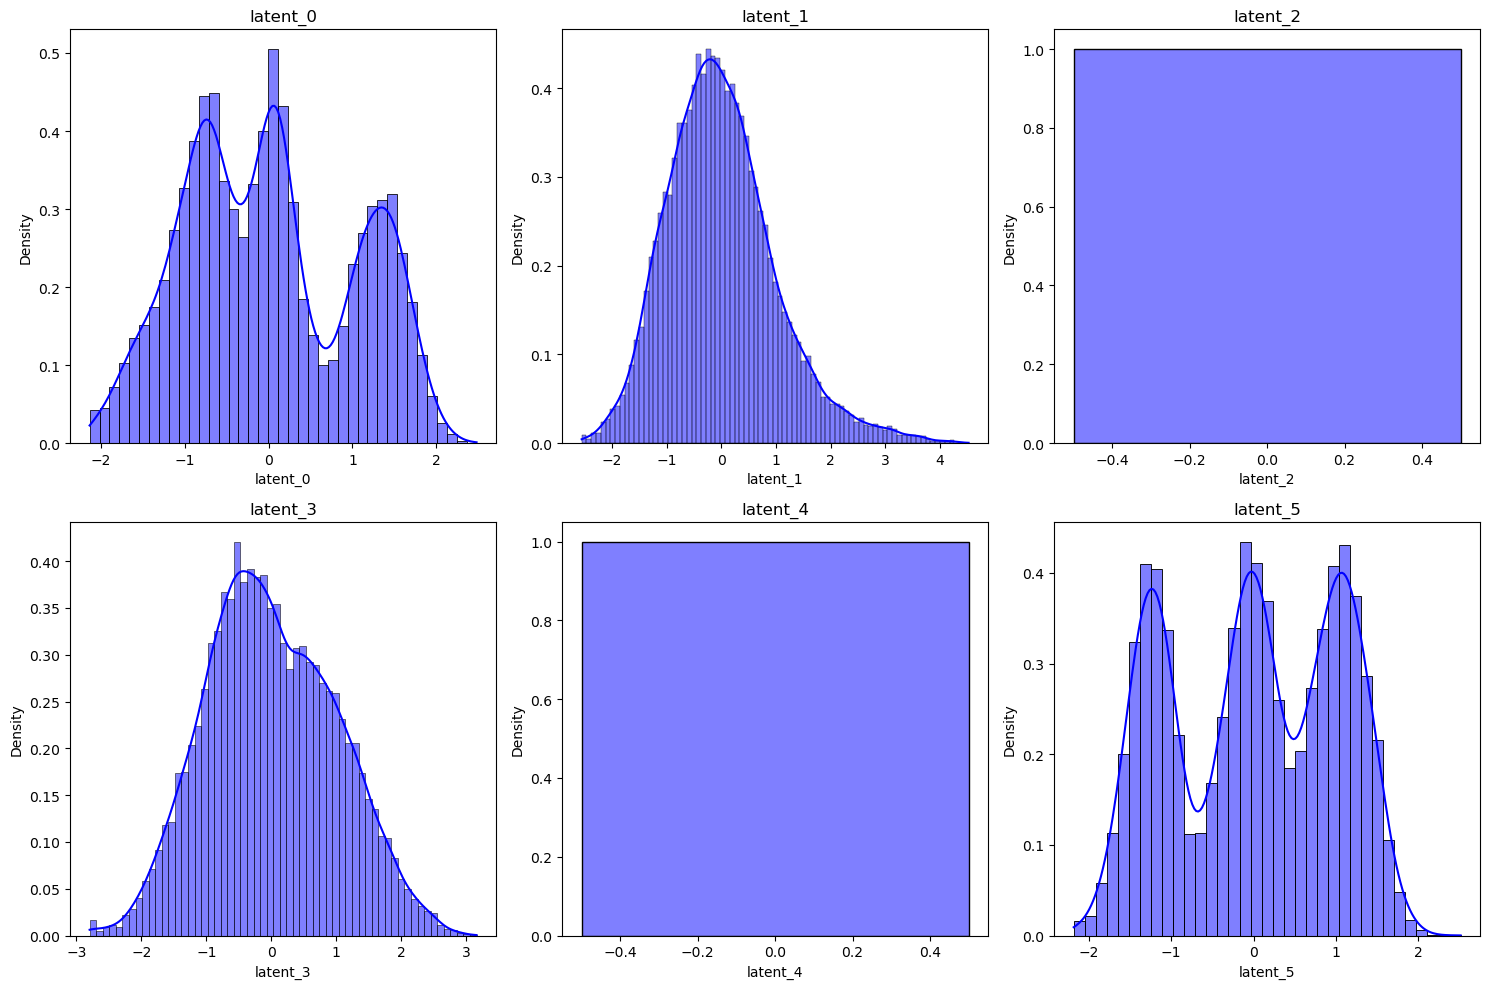

In [11]:
var_plotter(latent_rep_scaled, latent_rep_scaled.columns)

In [17]:
latent_rep.head()

,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5
customer_id,,,,,,
26709,0.867351,0.535021,0.0,0.693223,0.0,0.877658
47768,0.518716,0.353775,0.0,0.778371,0.0,1.556645
29757,0.165574,0.538191,0.0,0.810366,0.0,1.415488
42493,1.147437,0.504325,0.0,0.570849,0.0,0.194524
27655,0.985418,0.408180,0.0,0.503764,0.0,1.022120


**Outliers Separated**

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kme

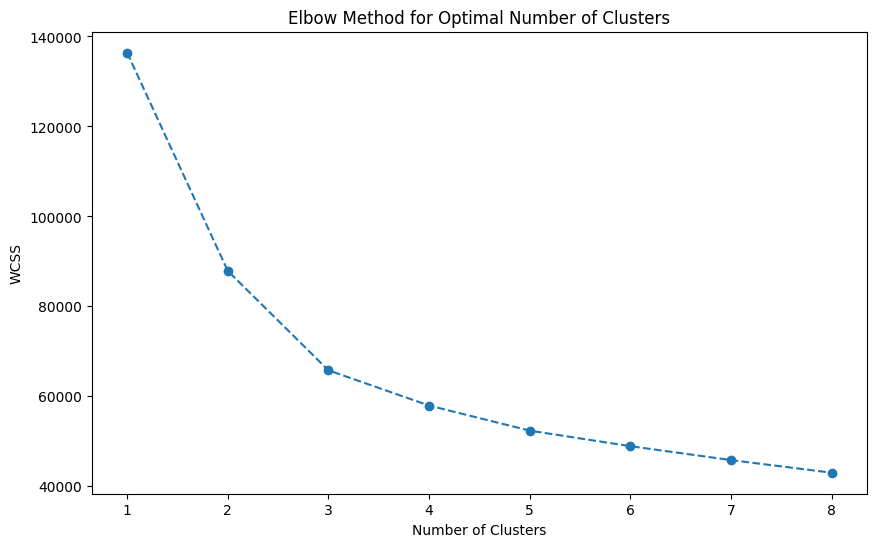

In [43]:
plot_elbow_method(latent_rep_scaled, max_clusters=8)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


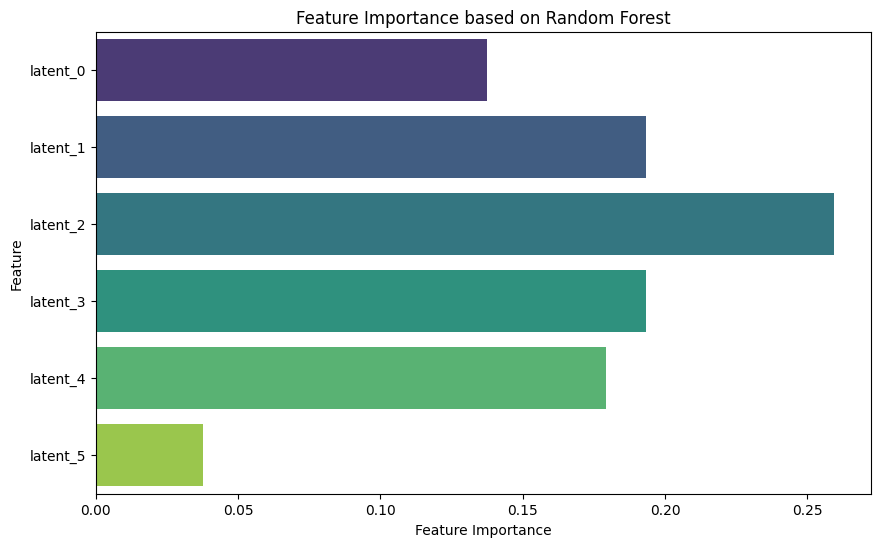

In [17]:
plot_feature_importance(latent_rep_scaled, n_clusters=5)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kme

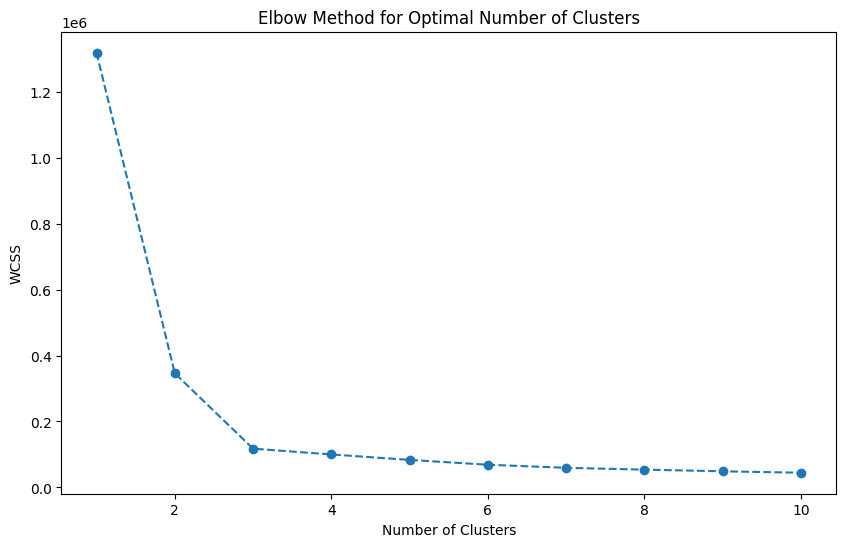

[1318057.3488005835,
 346063.843474122,
 117660.09690328469,
 100066.74432068162,
 83559.75422497594,
 68877.18941904134,
 59549.9442717693,
 53976.29312505026,
 48986.766236105286,
 44672.50436345484]

In [18]:
plot_elbow_and_silhouette(latent_rep_scaled_outliers)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


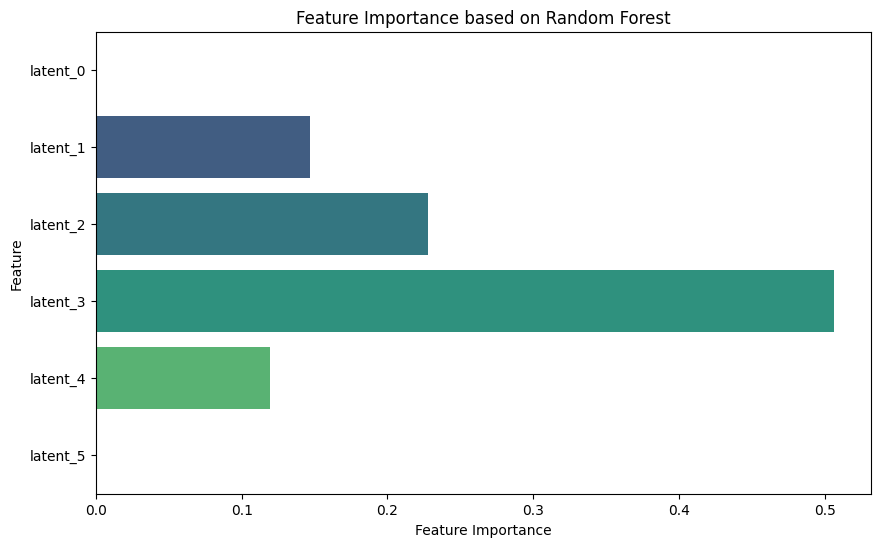

In [19]:
plot_feature_importance(latent_rep_scaled_outliers, n_clusters=3)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


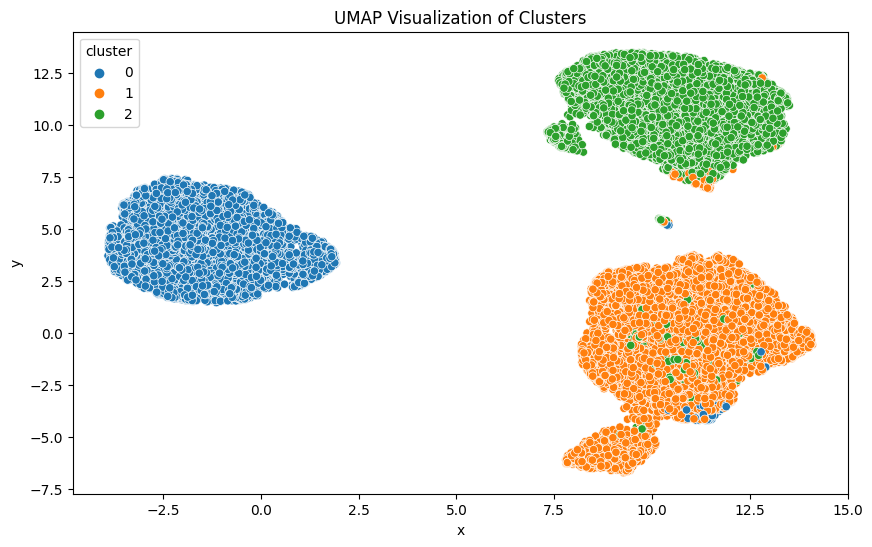

In [26]:
latent_rep_scaled_labeled = append_kmeans_clusters(latent_rep_scaled, n_clusters=3)
plot_umap_clusters(latent_rep_scaled_labeled)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


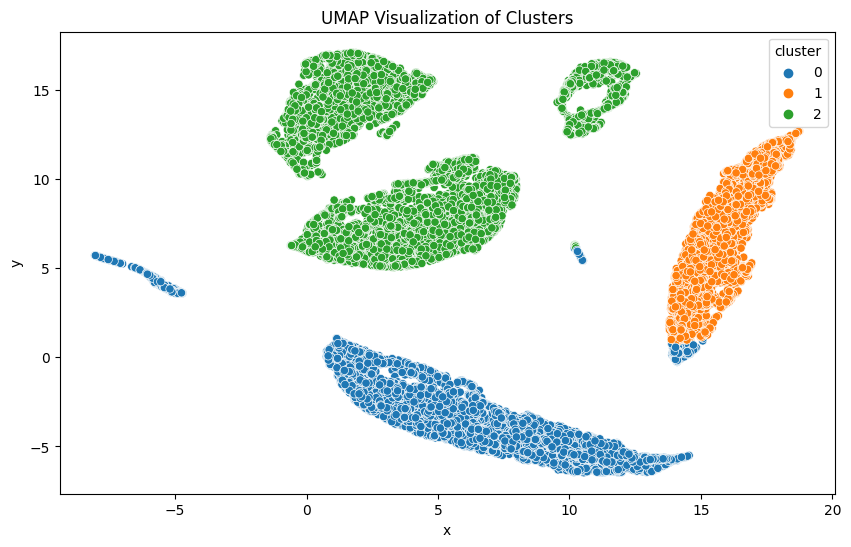

In [25]:
latent_rep_scaled_labeled_outliers = append_kmeans_clusters(latent_rep_scaled_outliers, n_clusters=3)
plot_umap_clusters(latent_rep_scaled_labeled_outliers)

**With Outliers**

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


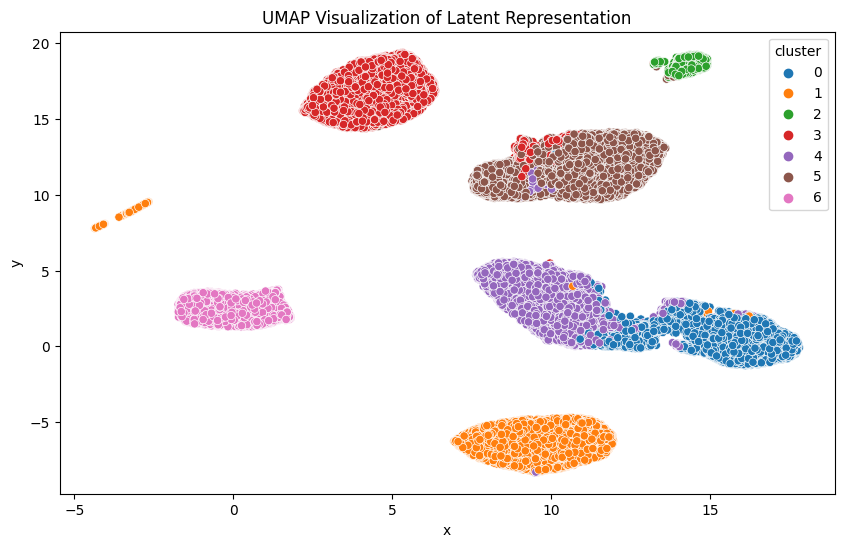

In [122]:
# apply KMeans
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(latent_rep_scaled)
latent_rep['cluster'] = kmeans.labels_
# apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_latent_rep = umap_model.fit_transform(latent_rep_scaled)
umap_latent_rep = pd.DataFrame(umap_latent_rep, columns=['x', 'y'])
umap_latent_rep['cluster'] = kmeans.labels_
# visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x', y='y', hue='cluster', data=umap_latent_rep, palette='tab10')
plt.title('UMAP Visualization of Latent Representation')
plt.show()

using df.drop(columns=spend_cols, inplace=True), n latent variables = 6, n clusters = 7, no outlier removal, minmax scaler

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


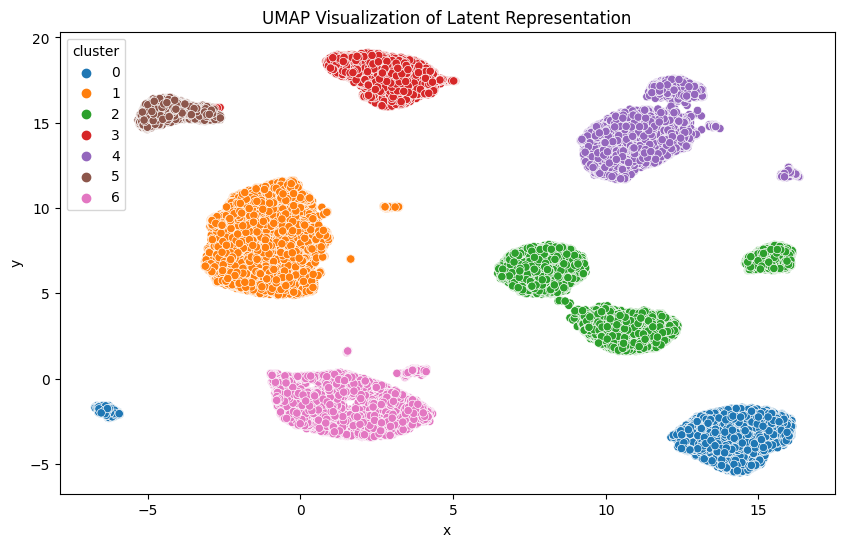

,x,y,cluster
0,14.941543,-2.776446,0
1,12.329451,17.209211,4
2,9.208262,6.711281,2
3,1.568414,1.642802,6
4,-4.595405,16.231741,5
...,...,...,...
43626,14.563020,-3.052151,0
43627,13.891803,-4.341884,0
43628,3.383058,16.842127,3
43629,-0.118683,-2.018278,6


In [39]:
kmeans_umap_visualization(latent_rep_scaled, n_clusters=7) 

com outliers, latent_dim = 6, RobustScaler()

# **Without Using Autoencoder**

In [27]:
customer_info_noencode = pd.read_csv(os.path.join(base_dir, 'customer_info_preproc.csv'), index_col='customer_id')
customer_info_noencode_outliers = pd.read_csv(os.path.join(base_dir, 'customer_info_preproc_outliers.csv'), index_col='customer_id')

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


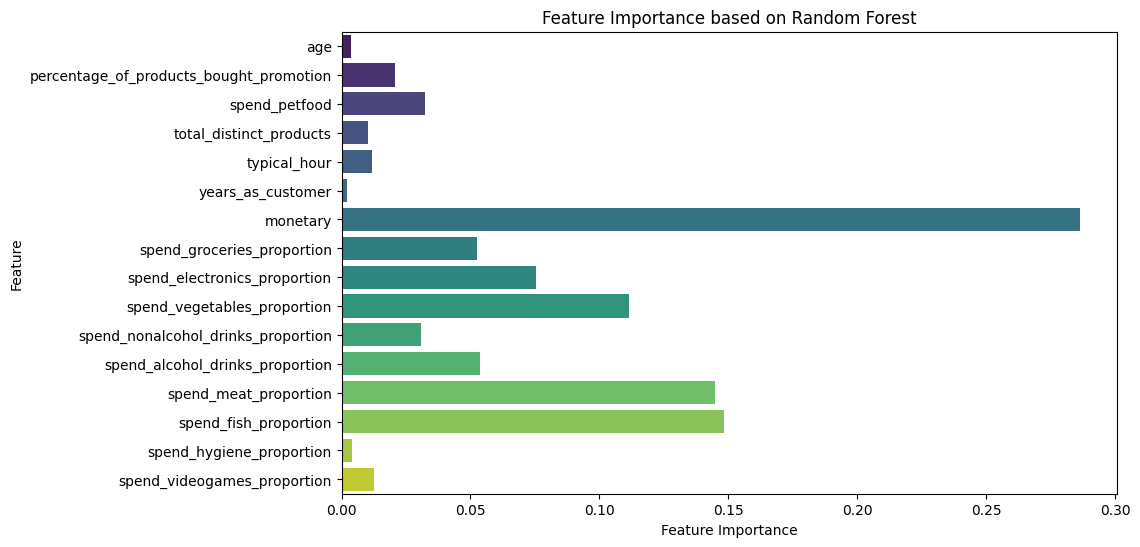

In [29]:
plot_feature_importance(customer_info_noencode, n_clusters=3)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


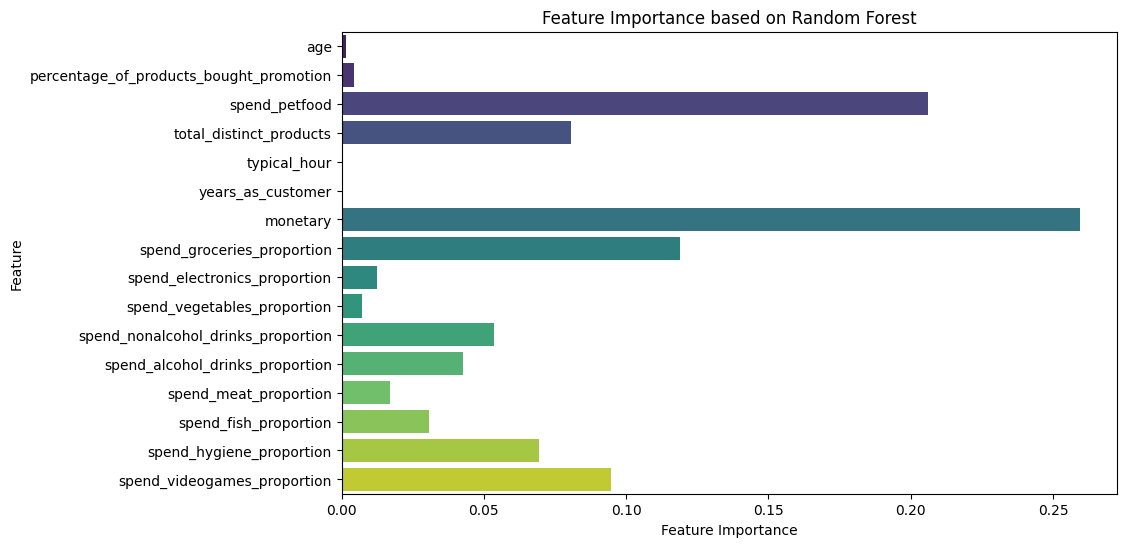

In [30]:
plot_feature_importance(customer_info_noencode_outliers, n_clusters=3)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


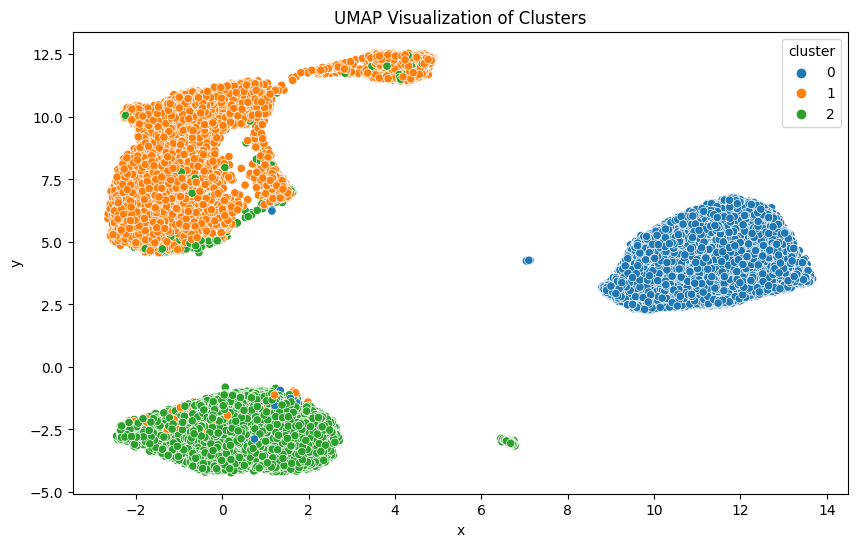

In [31]:
customer_info_noencode_labeled = append_kmeans_clusters(customer_info_noencode, n_clusters=3)
plot_umap_clusters(customer_info_noencode_labeled)

c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\vic\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


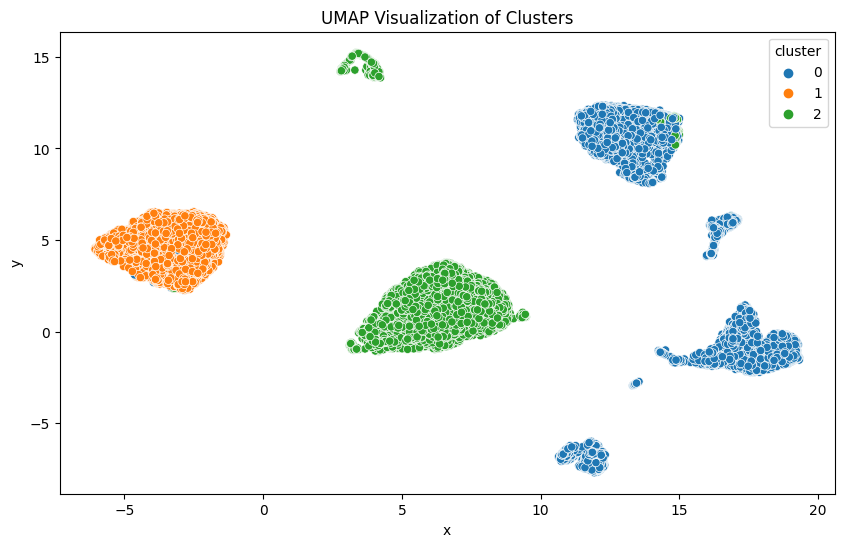

In [32]:
customer_info_noencode_labeled_outliers = append_kmeans_clusters(customer_info_noencode_outliers, n_clusters=3)
plot_umap_clusters(customer_info_noencode_labeled_outliers)

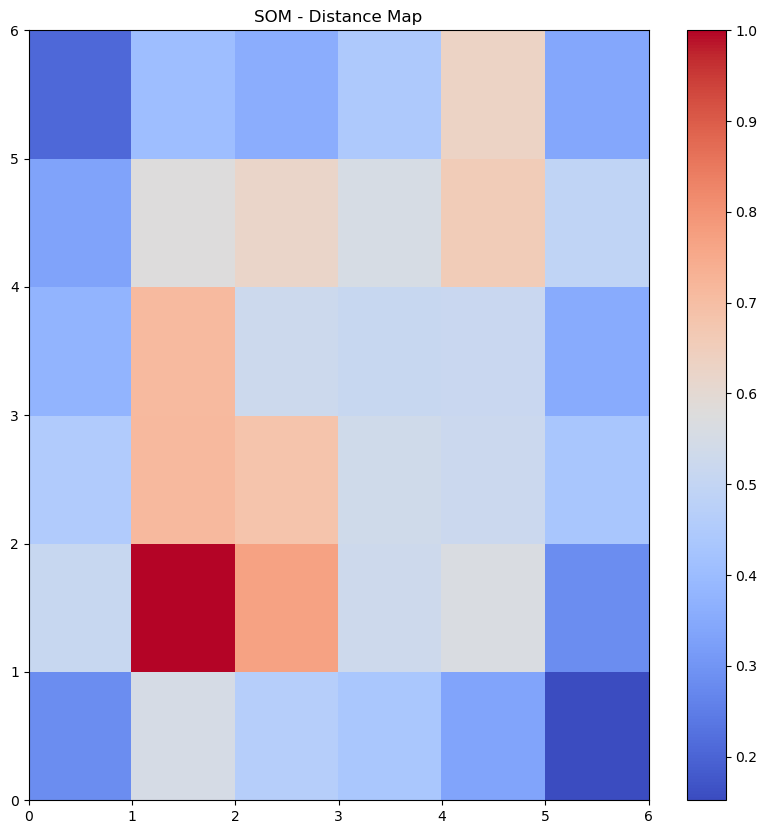

In [25]:
coco = train_and_plot_som(latent_rep_scaled)

In [31]:
distinct_values = coco['cluster'].unique()
print(distinct_values)

[ 0 26 18  1 21 19 10 32  9 11 14  3 31 30 17 20 35 13 34 25 16 22 12 33
 23  4 24  7 29  6 15  8 27  2  5 28]


c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\minisom.py:518: RuntimeWarning: invalid value encountered in divide
  return um/um.max()
c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\minisom.py:518: RuntimeWarning: invalid value encountered in divide
  return um/um.max()


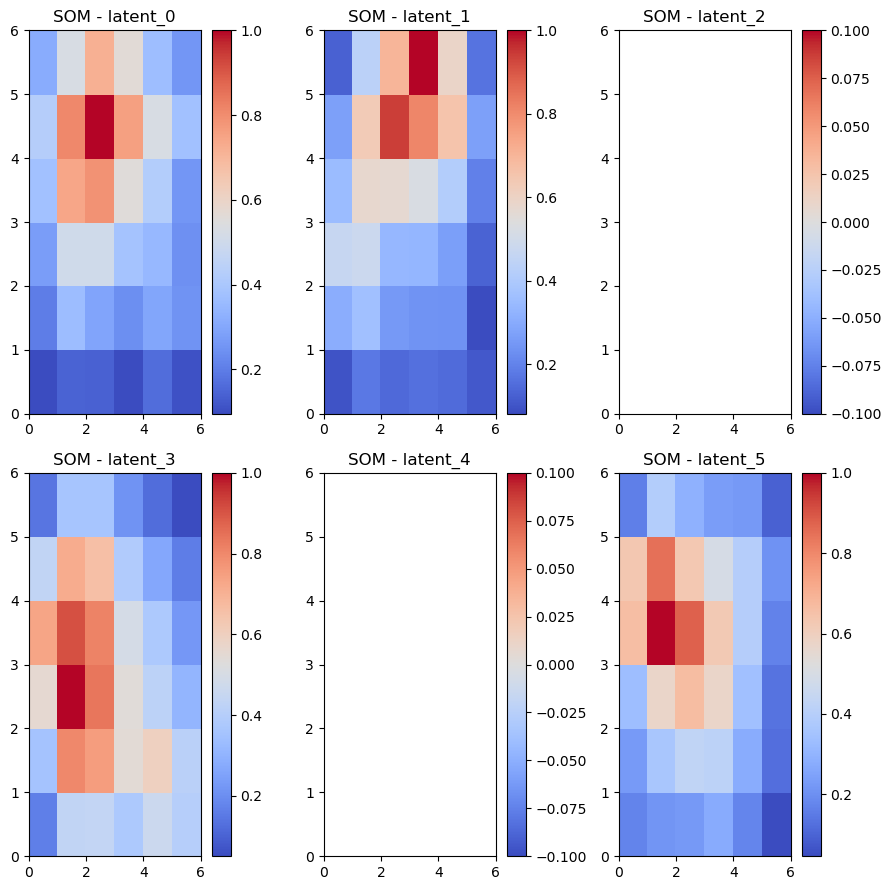

In [42]:
train_and_plot_som_per_variable(latent_rep_scaled)

c:\Users\Francisco Batista\.conda\envs\uni\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


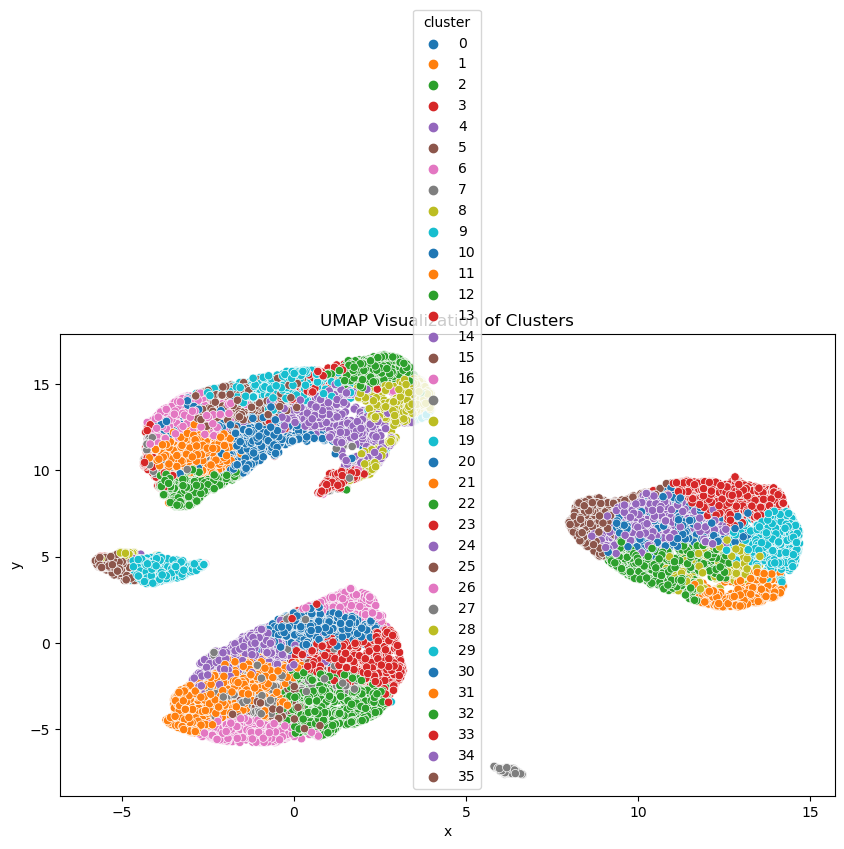

In [43]:
plot_umap_clusters(coco)

kkkk ganda merda